In [1]:
import warnings
warnings.filterwarnings("ignore")
from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import plotting
from custom_libs import best_restaurants
from custom_libs import dump

In [2]:
text_column_name = 'review'
cleaned_text_column_name = 'review_cleaned'

In [3]:
df = db.get_dataset("McDonald_s_Reviews")
preprocessing.add_id_column(df, columns=["latitude", "longitude"])
preprocessing.add_rating_number_column(df)
preprocessing.preprocess_df(df, text_column_name, cleaned_text_column_name)
df.head(2)

Number of unique ids:  40


reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   
1            2  McDonald's  Fast food restaurant   

                                       store_address   latitude  longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   
1  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   
1        1,240    5 days ago   

                                              review   rating  rating_number  \
0  Why does it look like someone spit on my food?...   1 star              1   
1  It'd McDonalds. It is what it is as far as the...  4 stars              4   

   id                                     review_cleaned  
0   9  look like someone spit food normal transaction...  
1   9  far food atmosphere go staff make difference f...

In [4]:
sentiment_our_column_name = 'sentiment_our'
sentiment_auto_column_name = 'sentiment_auto'

In [5]:
# Our model
model = dump.load_model("our_model")
vectorizer = dump.load_model("our_vectorizer")
df[sentiment_our_column_name] = model.predict(vectorizer.transform(df[cleaned_text_column_name]))

# SentimentIntensityAnalyzer model
classification.append_sentiment_for_each_row(df, cleaned_text_column_name, new_column_name=sentiment_auto_column_name)

# Results
df[[cleaned_text_column_name, sentiment_auto_column_name, sentiment_our_column_name]]

Loading model from: dump_models/our_model.pkl
Loading model from: dump_models/our_vectorizer.pkl


review_cleaned sentiment_auto  \
0      look like someone spit food normal transaction...       Positive   
1      far food atmosphere go staff make difference f...       Positive   
2      make mobile get speaker checked line move leav...       Negative   
3       crispy chicken sandwich customer service quick p        Neutral   
4      repeat time drive thru still manage mess suppo...       Negative   
...                                                  ...            ...   
33391                                        treat badly       Negative   
33392                                       service good       Positive   
33393                               remove hunger enough       Negative   
33394                       good lately become expensive       Positive   
33395                                     take good care       Positive   

      sentiment_our  
0          Negative  
1          Positive  
2          Negative  
3          Positive  
4          Negative  
...             ...  
33391      Negative  
33392      Positive  
33393      Negative  
33394      Positive  
33395      Positive  

[33396 rows x 3 columns]

In [6]:
# Rows with different sentiment
df_differences = df[df[sentiment_our_column_name] != df[sentiment_auto_column_name]]
df_differences.shape

(9706, 15)

In [7]:
df_differences = df_differences[[text_column_name, sentiment_auto_column_name, sentiment_our_column_name]]
df_differences.sample(20)

review sentiment_auto  \
13910  In the area above it is very hot! In the playg...       Negative   
18624                                       Cheap meals.        Neutral   
8869   So bad customers service  ...... we were here ...        Neutral   
20061  The chicken nuggets were overly greasy and see...       Positive   
16341  Claims to be 24 hours but itï¿½ï¿½ï¿½ï¿½ï¿½ï¿½...        Neutral   
17361  Workers are very rude wait to long to  take or...       Negative   
10642  One of two McDonald's stores in whole mid/sout...       Positive   
33304  Unpleasant smell.\n\nGotta get some cleaning t...       Negative   
3990                                             Neutral        Neutral   
9490   Unless I ask how much something extra costs, d...        Neutral   
7200   Service is fast and the always correct. Not mu...        Neutral   
10352  Just didn't feel safe eating inside I guess it...       Positive   
16643  No one should ever go to McDonald's for anythi...        Neutral   
16668  Be careful with drive thur they can forget you...       Negative   
10210  Drive thru multiple times after midnight and t...       Positive   
2375   The 2 for $4 is the cheapest you can get for b...        Neutral   
2955                                             Neutral        Neutral   
3566                            ýýýýýýýýýýýýýýýýýýýý ýýý        Neutral   
12652  Very slow compared to other McDonald's. Very c...       Positive   
9620   Ice coffee is my thing at McDonald's...4 to 5 ...        Neutral   

      sentiment_our  
13910       Neutral  
18624      Negative  
8869       Negative  
20061      Negative  
16341      Negative  
17361      Positive  
10642      Negative  
33304       Neutral  
3990       Positive  
9490       Positive  
7200       Positive  
10352      Negative  
16643      Positive  
16668      Positive  
10210       Neutral  
2375       Positive  
2955       Positive  
3566       Positive  
12652      Negative  
9620       Positive

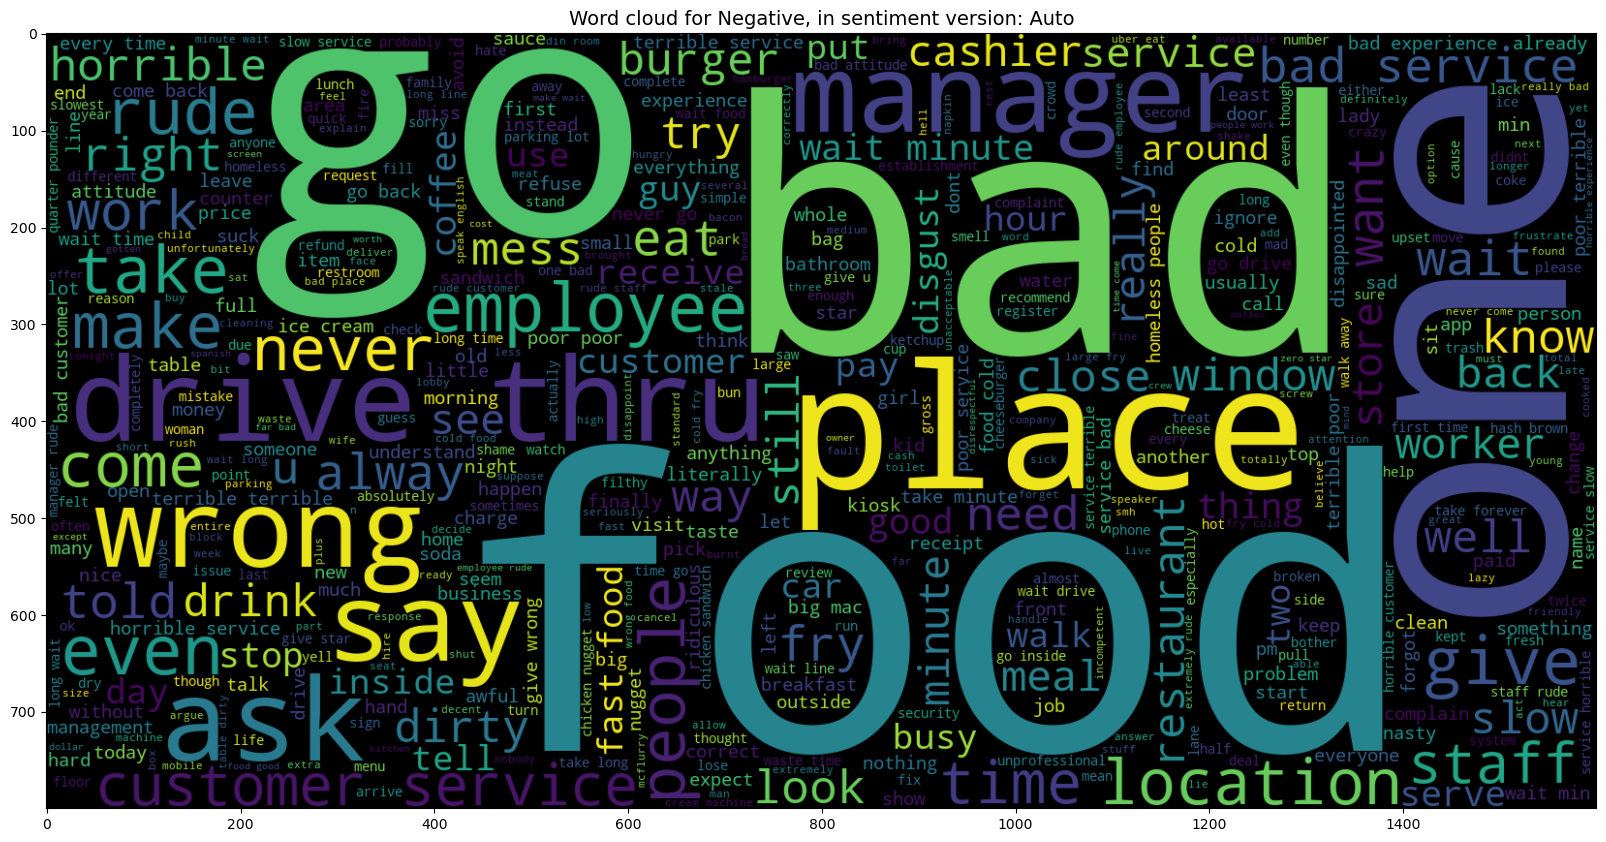

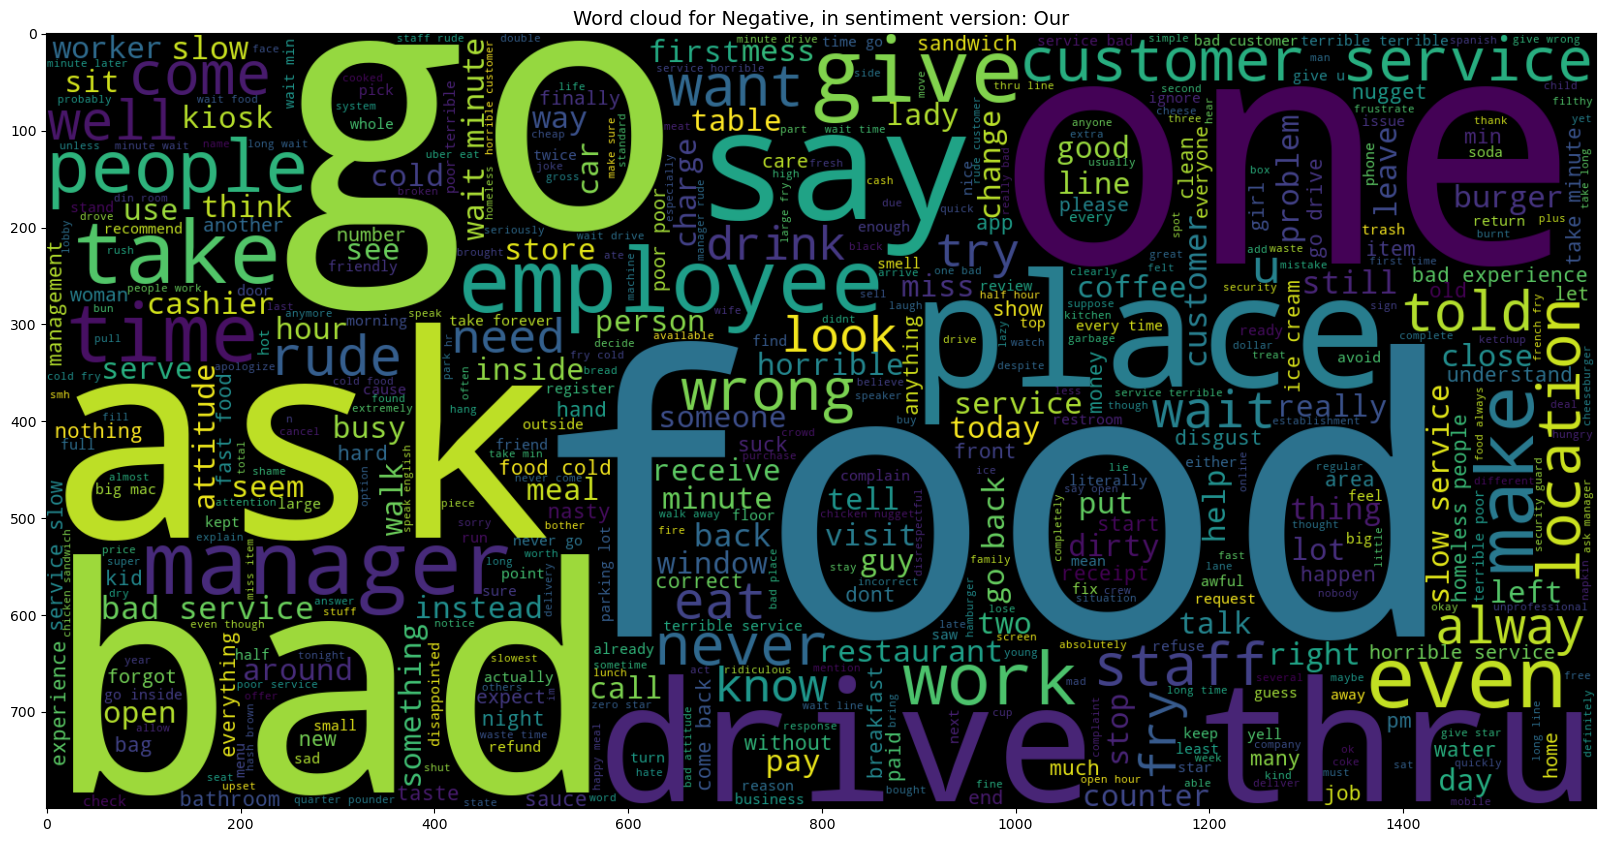

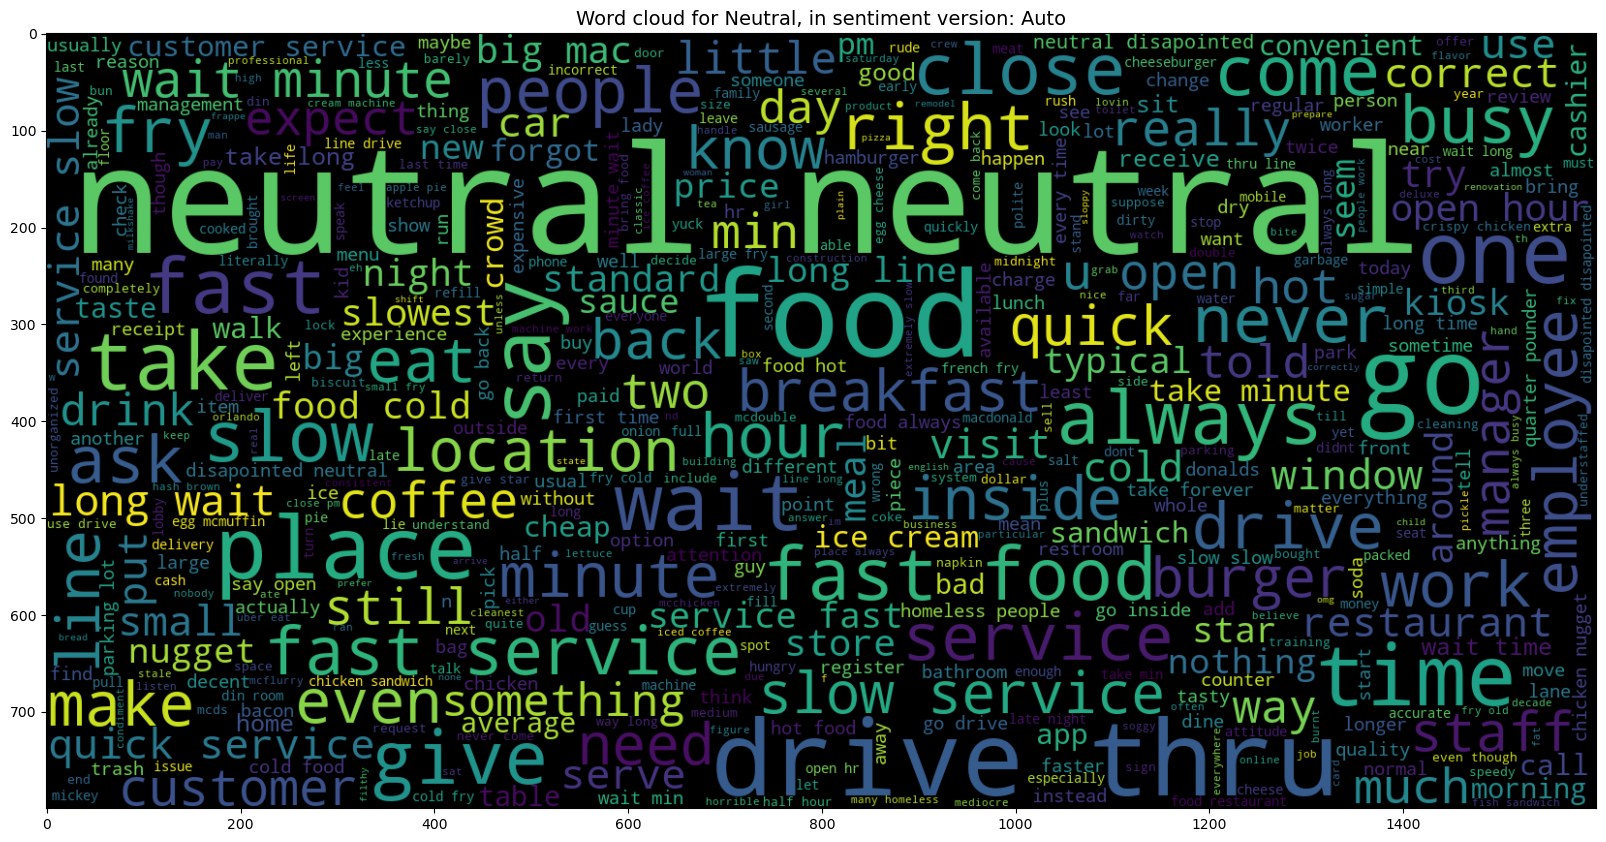

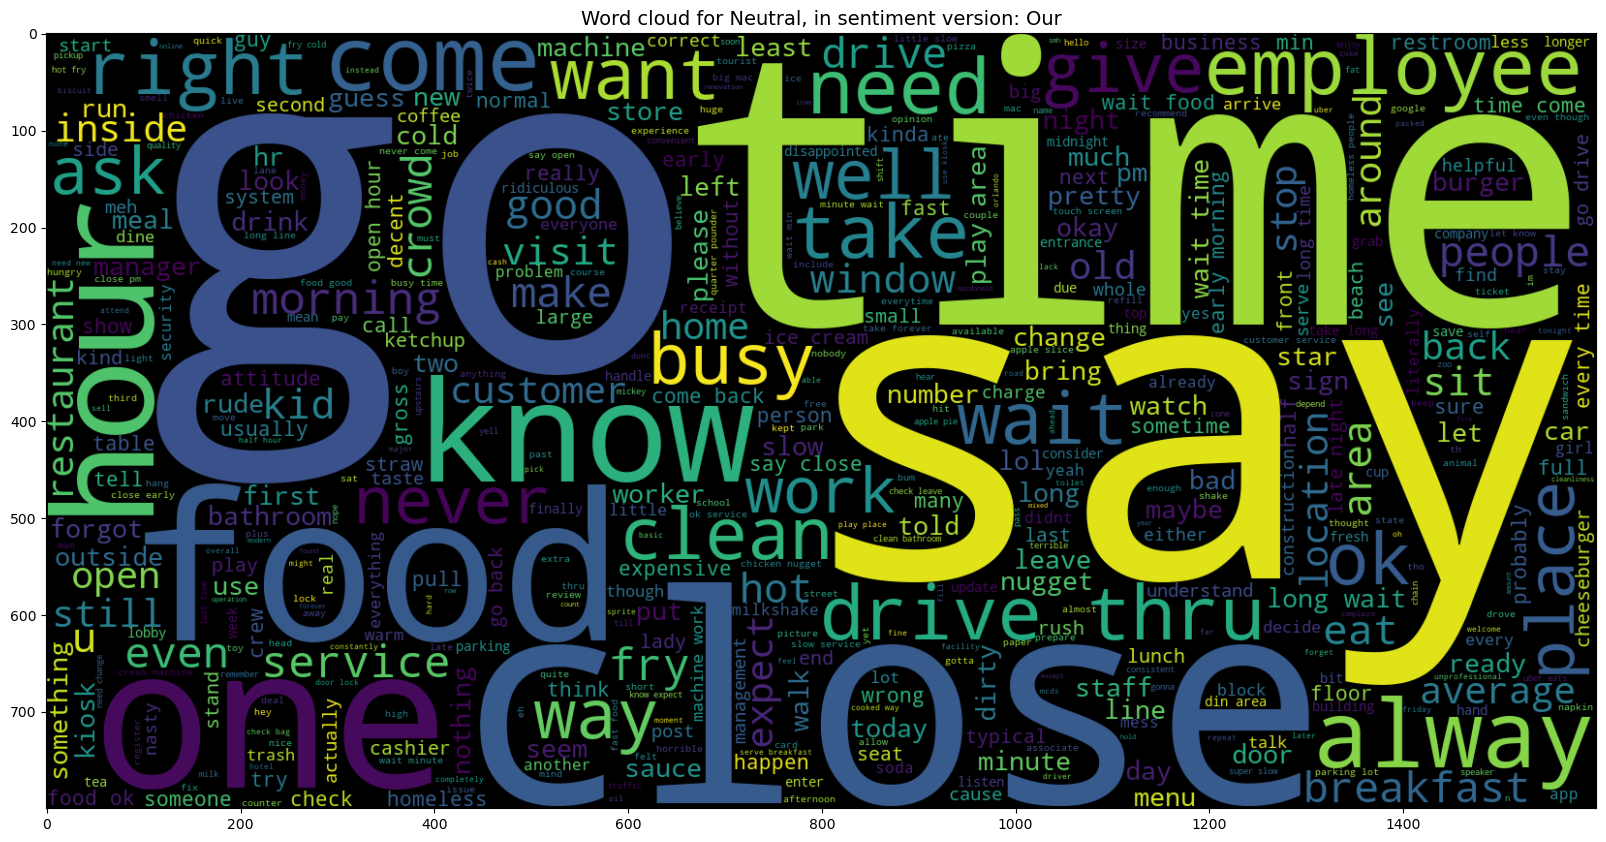

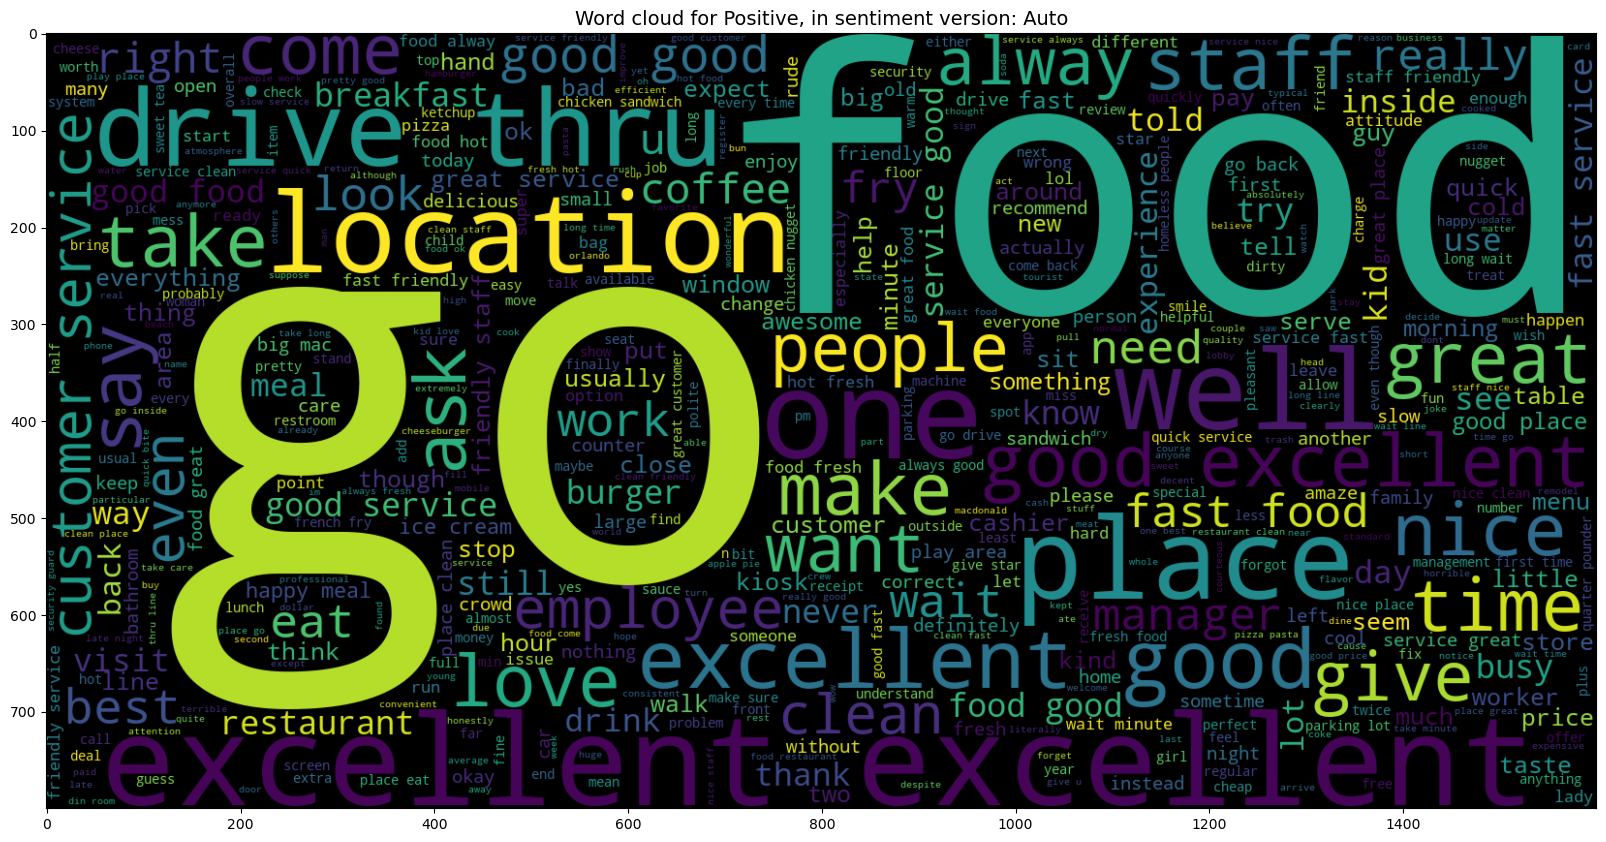

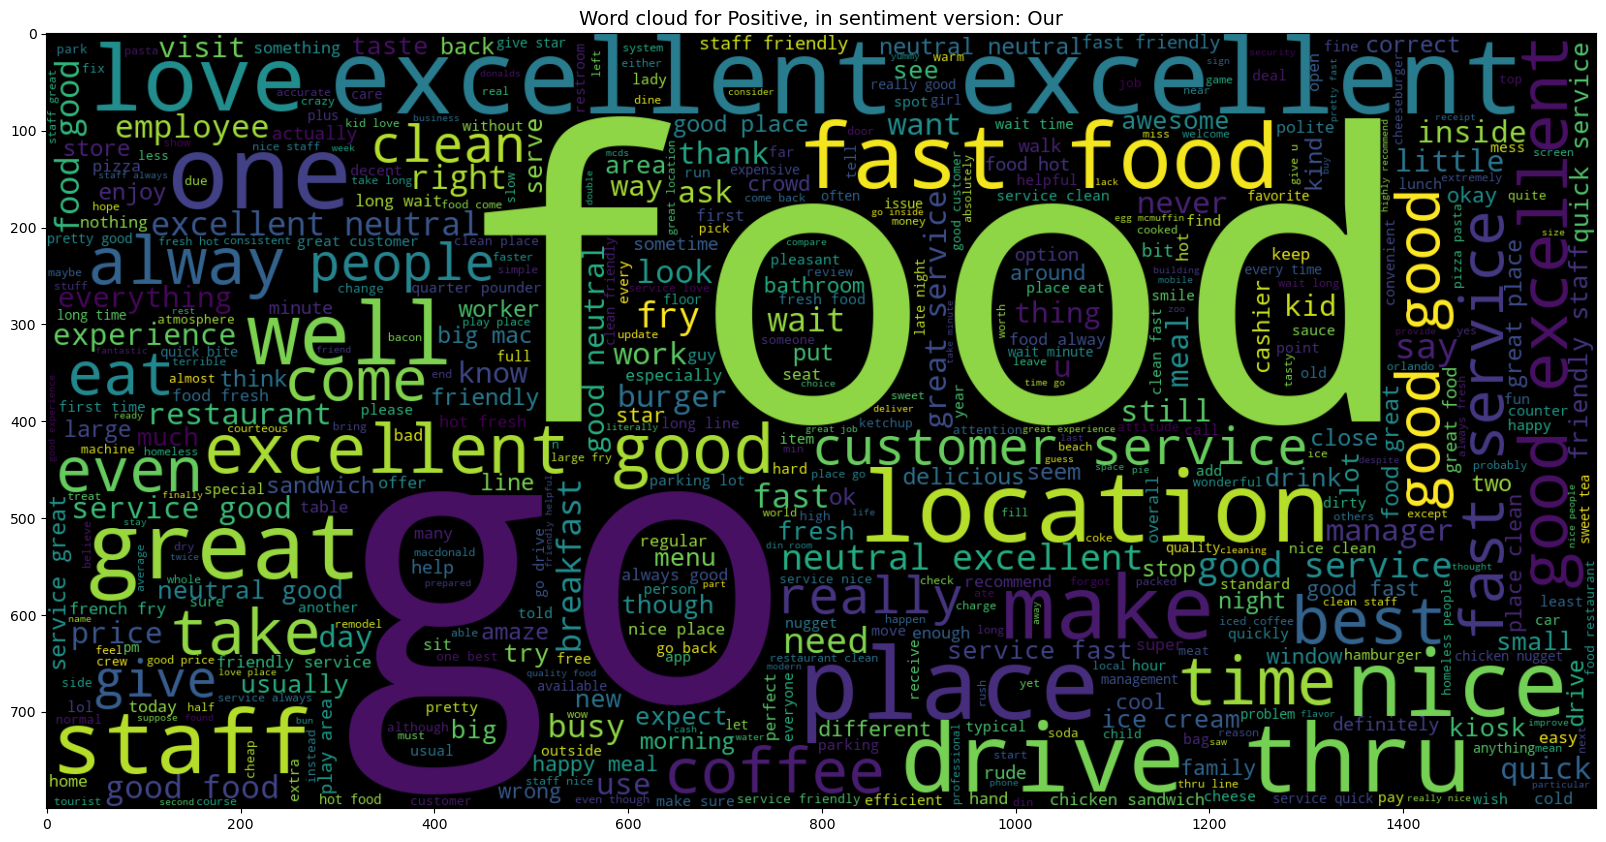

In [8]:
def plot_sentiment_word_clouds(df):
    for sentiment in classification.Sentiment.get_all():
        df_sentiment = df[(df[sentiment_auto_column_name]==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, cleaned_text_column_name, plt_name="Auto")
        df_sentiment = df[(df[sentiment_our_column_name]==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, cleaned_text_column_name, plt_name="Our")

plot_sentiment_word_clouds(df)

In [9]:
current_position = [30.460718, -97.792874]
max_distance = 20
best_rated_restaurant = best_restaurants.select_best_restaurant_from_stars(df, current_position, max_distance)
best_rated_restaurant

store_address   latitude  longitude
id                                                                    
8   8500 US-290, Austin, TX 78724, United States  30.329135 -97.660629

In [10]:
best_clf_column = sentiment_auto_column_name
best_feeling_restaurant = best_restaurants.select_best_restaurant_from_sentiment(df, current_position, max_distance, sentiment_column=best_clf_column)
best_feeling_restaurant

store_address   latitude  longitude
id                                                                         
9   13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874